# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code



In [63]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|medium\shigh\squality|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    #df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(int))
    
    ## encode numeric features
    #for column in ['pack','weight','height','width','length','surface_area']:
    #    encode_numeric_zscore(df,column)
    for column in ['weight']:
        encode_numeric_zscore(df,column)
    
    #for column in ['height','width','length']:
    #    df.drop(column,1,inplace=True)
        
    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Cross-Validate
#kf = KFold(5)

# Used before KFold
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)


Final score (RMSE): 32.52793884277344
['pack', 'weight', 'height', 'width', 'length', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'quality-Medium High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Post It Notes,-59.719971,False
item-Thumbtacks,-56.904186,False
item-Pencils,-50.110344,False
item-Paperclips,-44.058762,False
color-Red,-38.178513,False
color-Green,-25.862614,False
color-Blue,-11.869884,False
height,-10.232891,False
length,-8.184170,False
width,-6.139114,False


Intercept: [ 171.07705688]


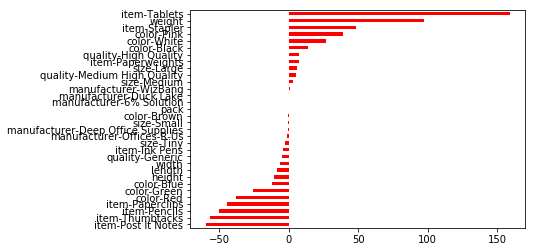

In [64]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

In [65]:
checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
if (0):
    oos_y = []
    oos_pred = []
    fold = 0
    
    for train, test in kf.split(x):
        fold+=1
        print("Fold #{}".format(fold))
        
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
    
model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dropout(0.01)) # Dropout Layer
model.add(Dense(25, activation='relu')) # Hidden 2
model.add(Dense(10, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu')) # Hidden 3 w/regularization
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
pred = model.predict(x_test)
    
#    oos_y.append(y_test)
#    oos_pred.append(pred)        

    


Train on 7500 samples, validate on 2500 samples
Epoch 1/10000
7500/7500 [==============================] - 1s 136us/step - loss: 10583.2156 - val_loss: 11132.5401
Epoch 2/10000
7500/7500 [==============================] - 0s 57us/step - loss: 7422.5652 - val_loss: 4223.0854
Epoch 3/10000
7500/7500 [==============================] - 0s 60us/step - loss: 3269.0210 - val_loss: 1678.9112
Epoch 4/10000
7500/7500 [==============================] - 0s 62us/step - loss: 1783.8170 - val_loss: 1115.9956
Epoch 5/10000
7500/7500 [==============================] - 0s 57us/step - loss: 1072.6385 - val_loss: 676.2012
Epoch 6/10000
7500/7500 [==============================] - 0s 58us/step - loss: 861.1920 - val_loss: 545.4521
Epoch 7/10000
7500/7500 [==============================] - 0s 57us/step - loss: 660.5917 - val_loss: 428.0436
Epoch 8/10000
7500/7500 [==============================] - 0s 56us/step - loss: 579.2083 - val_loss: 385.5396
Epoch 9/10000
7500/7500 [==============================] - 0

7500/7500 [==============================] - 0s 57us/step - loss: 225.5542 - val_loss: 171.3469
Epoch 75/10000
7500/7500 [==============================] - 0s 65us/step - loss: 249.8724 - val_loss: 182.4669
Epoch 76/10000
7500/7500 [==============================] - 0s 63us/step - loss: 208.7419 - val_loss: 169.6123
Epoch 77/10000
7500/7500 [==============================] - 0s 59us/step - loss: 208.3172 - val_loss: 219.7847
Epoch 78/10000
7500/7500 [==============================] - 0s 59us/step - loss: 212.0790 - val_loss: 196.2425
Epoch 79/10000
7500/7500 [==============================] - 0s 57us/step - loss: 225.3904 - val_loss: 182.8838
Epoch 80/10000
7500/7500 [==============================] - 0s 58us/step - loss: 204.3659 - val_loss: 195.9246
Epoch 81/10000
7500/7500 [==============================] - 0s 60us/step - loss: 219.1826 - val_loss: 165.1997
Epoch 82/10000
7500/7500 [==============================] - 0s 58us/step - loss: 228.1635 - val_loss: 194.4759
Epoch 83/10000
7

7500/7500 [==============================] - 1s 68us/step - loss: 180.2474 - val_loss: 152.7476
Epoch 148/10000
7500/7500 [==============================] - 0s 58us/step - loss: 192.4680 - val_loss: 163.3193
Epoch 149/10000
7500/7500 [==============================] - 0s 62us/step - loss: 192.4448 - val_loss: 173.7066
Epoch 150/10000
7500/7500 [==============================] - 0s 61us/step - loss: 180.2384 - val_loss: 194.5697
Epoch 151/10000
7500/7500 [==============================] - 0s 54us/step - loss: 178.1657 - val_loss: 174.7189
Epoch 152/10000
7500/7500 [==============================] - 0s 61us/step - loss: 183.8110 - val_loss: 173.2184
Epoch 153/10000
7500/7500 [==============================] - 0s 56us/step - loss: 183.9432 - val_loss: 166.4929
Epoch 154/10000
7500/7500 [==============================] - 0s 58us/step - loss: 187.5417 - val_loss: 174.8813
Epoch 155/10000
7500/7500 [==============================] - 0s 60us/step - loss: 180.7510 - val_loss: 150.4248
Epoch 15

7500/7500 [==============================] - 1s 144us/step - loss: 167.1338 - val_loss: 152.9416
Epoch 221/10000
7500/7500 [==============================] - 1s 85us/step - loss: 202.8664 - val_loss: 155.3391
Epoch 222/10000
7500/7500 [==============================] - 0s 59us/step - loss: 164.5747 - val_loss: 148.2870
Epoch 223/10000
7500/7500 [==============================] - 1s 123us/step - loss: 162.3708 - val_loss: 153.5966
Epoch 224/10000
7500/7500 [==============================] - 1s 98us/step - loss: 159.2824 - val_loss: 170.7454
Epoch 225/10000
7500/7500 [==============================] - 1s 88us/step - loss: 174.2808 - val_loss: 169.4576
Epoch 226/10000
7500/7500 [==============================] - 0s 60us/step - loss: 163.2572 - val_loss: 149.0770
Epoch 227/10000
7500/7500 [==============================] - 0s 55us/step - loss: 167.3406 - val_loss: 158.5503
Epoch 228/10000
7500/7500 [==============================] - 0s 52us/step - loss: 159.9893 - val_loss: 150.6091
Epoch 

7500/7500 [==============================] - 0s 51us/step - loss: 154.4083 - val_loss: 141.2820
Epoch 294/10000
7500/7500 [==============================] - 0s 48us/step - loss: 155.1712 - val_loss: 138.0855
Epoch 295/10000
7500/7500 [==============================] - 0s 50us/step - loss: 195.9686 - val_loss: 575.7140
Epoch 296/10000
7500/7500 [==============================] - 0s 48us/step - loss: 189.1106 - val_loss: 144.1228
Epoch 297/10000
7500/7500 [==============================] - 0s 49us/step - loss: 158.3457 - val_loss: 148.8284
Epoch 298/10000
7500/7500 [==============================] - 0s 49us/step - loss: 150.1268 - val_loss: 149.9901
Epoch 299/10000
7500/7500 [==============================] - 0s 48us/step - loss: 154.9535 - val_loss: 153.6228
Epoch 300/10000
7500/7500 [==============================] - 0s 50us/step - loss: 155.5853 - val_loss: 143.9706
Epoch 301/10000
7500/7500 [==============================] - 0s 48us/step - loss: 156.9603 - val_loss: 150.1129
Epoch 30

7500/7500 [==============================] - 1s 70us/step - loss: 151.5275 - val_loss: 146.5471
Epoch 367/10000
7500/7500 [==============================] - 0s 60us/step - loss: 150.9928 - val_loss: 162.1042
Epoch 368/10000
7500/7500 [==============================] - 1s 67us/step - loss: 147.3499 - val_loss: 197.7840
Epoch 369/10000
7500/7500 [==============================] - 1s 78us/step - loss: 150.3397 - val_loss: 211.7762
Epoch 370/10000
7500/7500 [==============================] - 1s 74us/step - loss: 151.3761 - val_loss: 141.6614
Epoch 371/10000
7500/7500 [==============================] - 1s 76us/step - loss: 153.1580 - val_loss: 246.4148
Epoch 372/10000
7500/7500 [==============================] - 1s 81us/step - loss: 152.2919 - val_loss: 139.2394
Epoch 373/10000
7500/7500 [==============================] - 1s 80us/step - loss: 149.4743 - val_loss: 136.1554
Epoch 374/10000
7500/7500 [==============================] - 1s 74us/step - loss: 180.4700 - val_loss: 255.4834
Epoch 37

7500/7500 [==============================] - 0s 58us/step - loss: 144.2362 - val_loss: 138.2847
Epoch 440/10000
7500/7500 [==============================] - 0s 56us/step - loss: 150.1783 - val_loss: 194.0664
Epoch 441/10000
7500/7500 [==============================] - 0s 58us/step - loss: 147.7319 - val_loss: 137.0457
Epoch 442/10000
7500/7500 [==============================] - 0s 58us/step - loss: 142.9853 - val_loss: 151.2804
Epoch 443/10000
7500/7500 [==============================] - 0s 59us/step - loss: 156.6739 - val_loss: 139.6940
Epoch 444/10000
7500/7500 [==============================] - 0s 64us/step - loss: 148.9825 - val_loss: 144.8353
Epoch 445/10000
7500/7500 [==============================] - 1s 68us/step - loss: 144.6735 - val_loss: 140.1530
Epoch 446/10000
7500/7500 [==============================] - 1s 71us/step - loss: 144.8555 - val_loss: 175.5771
Epoch 447/10000
7500/7500 [==============================] - 1s 72us/step - loss: 144.1301 - val_loss: 135.6942
Epoch 44

7500/7500 [==============================] - 1s 69us/step - loss: 140.9486 - val_loss: 149.6207
Epoch 513/10000
7500/7500 [==============================] - 0s 55us/step - loss: 140.7035 - val_loss: 143.5770
Epoch 514/10000
7500/7500 [==============================] - 0s 62us/step - loss: 147.8332 - val_loss: 145.6078
Epoch 515/10000
7500/7500 [==============================] - 0s 56us/step - loss: 146.7280 - val_loss: 164.0243
Epoch 516/10000
7500/7500 [==============================] - 0s 66us/step - loss: 138.9461 - val_loss: 135.7538
Epoch 517/10000
7500/7500 [==============================] - 0s 58us/step - loss: 144.3438 - val_loss: 136.9056
Epoch 518/10000
7500/7500 [==============================] - 0s 60us/step - loss: 207.2210 - val_loss: 255.2010
Epoch 519/10000
7500/7500 [==============================] - 0s 58us/step - loss: 138.2749 - val_loss: 140.6229
Epoch 520/10000
7500/7500 [==============================] - 1s 67us/step - loss: 134.6465 - val_loss: 144.7129
Epoch 52

7500/7500 [==============================] - 1s 73us/step - loss: 137.2977 - val_loss: 140.0101
Epoch 586/10000
7500/7500 [==============================] - 0s 54us/step - loss: 130.6558 - val_loss: 148.3223
Epoch 587/10000
7500/7500 [==============================] - 1s 68us/step - loss: 138.7822 - val_loss: 137.7238
Epoch 588/10000
7500/7500 [==============================] - 0s 65us/step - loss: 139.2597 - val_loss: 138.7731
Epoch 589/10000
7500/7500 [==============================] - 0s 65us/step - loss: 135.8062 - val_loss: 148.7862
Epoch 590/10000
7500/7500 [==============================] - 1s 69us/step - loss: 133.8895 - val_loss: 141.8993
Epoch 591/10000
7500/7500 [==============================] - 1s 68us/step - loss: 152.1341 - val_loss: 143.9916
Epoch 592/10000
7500/7500 [==============================] - 0s 66us/step - loss: 147.2859 - val_loss: 138.6997
Epoch 593/10000
7500/7500 [==============================] - 1s 72us/step - loss: 131.9015 - val_loss: 189.1203
Epoch 59

In [60]:
# Measure this fold's RMSE
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Fold score (RMSE): {}".format(score))

Fold score (RMSE): 12.331077575683594


In [13]:
# Build the oos prediction list and calculate the error.
#oos_y = np.concatenate(oos_y)
#oos_pred = np.concatenate(oos_pred)
#score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
#print("Final, out of sample score (RMSE): {}".format(score)) 

Final, out of sample score (RMSE): 12.102914810180664


In [20]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

In [61]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)


In [62]:
cost = [n if n > 0 else 0 for n in pred_submit[:,0]]
df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)